# Tehtävä 6: Kokonaishedelmällisyysluku ja kuvaukset

Tässä notebookissa:
1. Määritetään vuosilista (1776–2024) ja JSON-stat2-payload PX-Web-pyyntöön.
2. Luodaan funktio `fetch_pxweb_data(url, payload)`, joka hakee JSON-stat2-datan ja muuntaa sen DataFrameksi.
3. Haetaan kokonaishedelmällisyysluvut (tfr) vuosilta 1776–2024 ja näytetään DataFramen yläosa (top 10 riviä) sekä rivien kokonaismäärä.
4. Piirretään ja tallennetaan kolme kuvaajaa:
   - Viivakuvaaja (line plot) hedelmällisyysluvun kehityksestä 1776–2024.
   - Pylväskaavio (bar plot) vuosien 2015–2024 hedelmällisyysluvuista.
   - Ympyrädiagrammi (pie chart) hedelmällisyysluvun osuuksista neljään vuosisatakuormaan jaetaan: 18., 19., 20. ja 21. vuosisata.

## 1) Kirjastojen tuonti ja muuttujien määrittely

Tuodaan tarvittavat kirjastot (`requests`, `pandas`, `matplotlib.pyplot`, `sys`, `json`),  
määritellään PX-WEB-URL, vuosilista `all_years` ja JSON-stat2-payload.

In [14]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import sys
import json

# 1) WORKING PX-WEB URL
PXWEB_URL = (
    "https://pxdata.stat.fi/PxWeb/api/v1/fi/StatFin/"
    "synt/statfin_synt_pxt_12dt.px"
)

# 2) Vuosilista 1776–2024 (täsmälleen metadata-kuvauksen mukaisesti)
all_years = [
    "1776","1777","1778","1779","1780","1781","1782","1783","1784","1785","1786","1787","1788","1789","1790","1791",
    "1792","1793","1794","1795","1796","1797","1798","1799","1800","1801","1802","1803","1804","1805","1806","1807",
    "1808","1809","1810","1811","1812","1813","1814","1815","1816","1817","1818","1819","1820","1821","1822","1823",
    "1824","1825","1826","1827","1828","1829","1830","1831","1832","1833","1834","1835","1836","1837","1838","1839",
    "1840","1841","1842","1843","1844","1845","1846","1847","1848","1849","1850","1851","1852","1853","1854","1855",
    "1856","1857","1858","1859","1860","1861","1862","1863","1864","1865","1866","1867","1868","1869","1870","1871",
    "1872","1873","1874","1875","1876","1877","1878","1879","1880","1881","1882","1883","1884","1885","1886","1887",
    "1888","1889","1890","1891","1892","1893","1894","1895","1896","1897","1898","1899","1900","1901","1902","1903",
    "1904","1905","1906","1907","1908","1909","1910","1911","1912","1913","1914","1915","1916","1917","1918","1919",
    "1920","1921","1922","1923","1924","1925","1926","1927","1928","1929","1930","1931","1932","1933","1934","1935",
    "1936","1937","1938","1939","1940","1941","1942","1943","1944","1945","1946","1947","1948","1949","1950","1951",
    "1952","1953","1954","1955","1956","1957","1958","1959","1960","1961","1962","1963","1964","1965","1966","1967",
    "1968","1969","1970","1971","1972","1973","1974","1975","1976","1977","1978","1979","1980","1981","1982","1983",
    "1984","1985","1986","1987","1988","1989","1990","1991","1992","1993","1994","1995","1996","1997","1998","1999",
    "2000","2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015",
    "2016","2017","2018","2019","2020","2021","2022","2023","2024"
]

# 3) JSON-stat2 Payload: haetaan kaikki vuodet ja Tiedot='tfr'
query_payload = {
    "query": [
        {
            "code": "Vuosi",
            "selection": {
                "filter": "item",
                "values": all_years
            }
        },
        {
            "code": "Tiedot",   
            "selection": {
                "filter": "item",
                "values": ["tfr"]
            }
        }
    ],
    "response": {
        "format": "json-stat2"
    }
}

## 2) Funktio `fetch_pxweb_data`

Määritellään funktio, joka lähettää POST-pyynnön PX-WEB-URL:iin,  
purkaa JSON-stat2-datan ja palauttaa pandas DataFramen sarakkeilla  
`['Year', 'Indicator', 'FertilityRate']`.

In [15]:
def fetch_pxweb_data(url: str, payload: dict) -> pd.DataFrame:
    """
    Lähettää POST-pyynnön PXWEB_URL:iin JSON-stat2-payloadilla.
    Purkaa saadun JSON-data rakenteen ja muuntaa sen DataFrameksi,
    jossa sarakkeet ['Year', 'Indicator', 'FertilityRate'].
    """
    try:
        resp = requests.post(url, json=payload, timeout=30)
        resp.raise_for_status()
    except requests.RequestException as e:
        if hasattr(e, "response") and e.response is not None:
            print("\n=== RESPONSE TEXT ===\n", e.response.text, file=sys.stderr)
        print("ERROR: Failed to fetch data:", e, file=sys.stderr)
        sys.exit(1)

    text = resp.text.strip()
    if len(text) == 0:
        print("\n=== RESPONSE WAS EMPTY ===\n", file=sys.stderr)
        sys.exit(1)

    try:
        json_data = resp.json()
    except ValueError:
        print("\n=== RESPONSE IS NOT JSON (raw text below) ===\n", text, file=sys.stderr)
        sys.exit(1)

    # JSON-stat2 voi olla sisällä avaimessa "dataset" tai olla suoraan top-tason objektina
    if "dataset" in json_data:
        ds = json_data["dataset"]
    elif json_data.get("class") == "dataset":
        ds = json_data
    else:
        print(
            "\n=== JSON did not contain 'dataset' nor class='dataset'. Full JSON: ===\n",
            json.dumps(json_data, ensure_ascii=False, indent=2),
            file=sys.stderr
        )
        sys.exit(1)

    dims = ds["dimension"]
    # dims.keys() pitäisi olla {'Vuosi','Tiedot','value'}
    dim_keys = [k for k in dims.keys() if k != "value"]  # esim. ['Vuosi','Tiedot']

    # 1) Jokaisen dimension "index"-lista:
    index_lists = [dims[key]["category"]["index"] for key in dim_keys]

    # 2) MultiIndex kartesiolaisesta tulostaulusta:
    mindex = pd.MultiIndex.from_product(index_lists, names=dim_keys)

    # 3) Tasoitettu "value"-lista
    values = ds["value"]

    # 4) DataFrame rakentaminen ja uudelleennimeäminen:
    df = pd.DataFrame({"Value": values}, index=mindex).reset_index()
    df = df.rename(columns={
        "Vuosi": "Year",
        "Tiedot": "Indicator",
        "Value": "FertilityRate"
    })

    return df

## 3) Haetaan data ja näytetään top 10 riviä

Kutsutaan `fetch_pxweb_data`, tulostetaan DataFramen 10 ensimmäistä riviä ja rivien kokonaismäärä.

In [16]:
df_fertility = fetch_pxweb_data(PXWEB_URL, query_payload)

# Näytetään vain 10 ensimmäistä riviä ja rivien kokonaismäärä
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)

print("=== Sample of the Fertility DataFrame (Top 10 rows) ===\n")
df_fertility.head(10)

=== Sample of the Fertility DataFrame (Top 10 rows) ===



,Year,Indicator,FertilityRate
0,1776,tfr,5.42
1,1777,tfr,5.51
2,1778,tfr,5.82
3,1779,tfr,5.91
4,1780,tfr,5.71
5,1781,tfr,5.17
6,1782,tfr,5.74
7,1783,tfr,5.42
8,1784,tfr,5.79
9,1785,tfr,5.39


In [17]:
print(f"\n(total rows returned = {len(df_fertility)})")


(total rows returned = 249)


## 4) Viivakuvaaja (Line plot): Hedelmällisyysluvun kehitys 1776–2024

Muutetaan `Year`-sarake aikatyyppiseksi ja piirretään ajan funktiona.
Kuvaaja tallennetaan tiedostoon `fertility_rate_trend_line.png`.

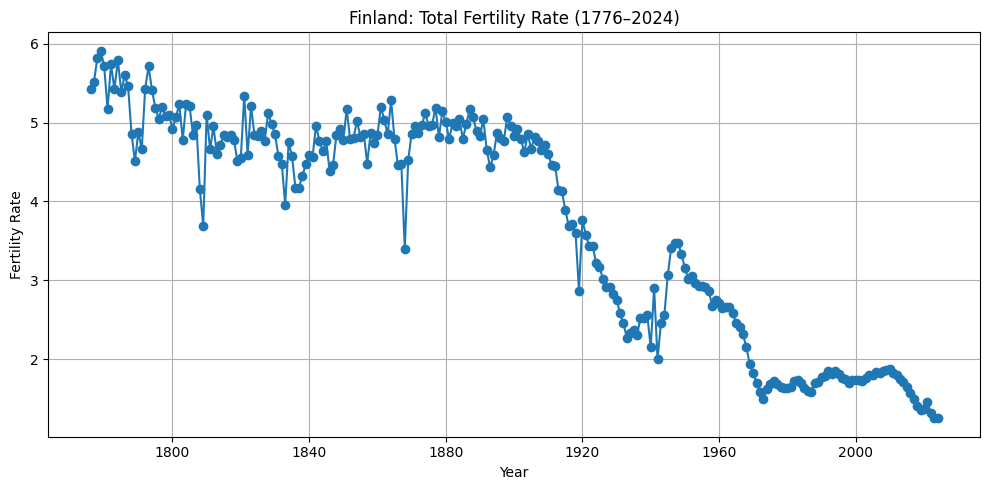

In [18]:
# Kopioidaan ja järjestetään data aikajärjestykseen
df_line = df_fertility.copy()
df_line["Year_dt"] = pd.to_datetime(df_line["Year"], format="%Y")
df_line = df_line.sort_values("Year_dt")

plt.figure(figsize=(10, 5))
plt.plot(
    df_line["Year_dt"],
    df_line["FertilityRate"],
    marker="o",
    linestyle="-"
)
plt.title("Finland: Total Fertility Rate (1776–2024)")
plt.xlabel("Year")
plt.ylabel("Fertility Rate")
plt.grid(True)
plt.tight_layout()
plt.savefig("fertility_rate_trend_line.png")
plt.show()

## 5) Pylväskaavio (Bar plot): Vuodet 2015–2024

Suodatetaan DataFrame vuodet 2015–2024 ja piirretään pylväskaavio, jossa arvojen päälle tulee lukuarvo.
Kuvaaja tallennetaan tiedostoon `fertility_rate_by_year_bar.png`.

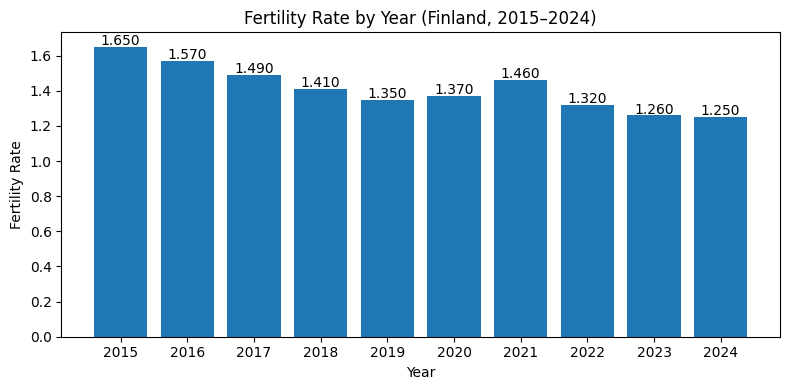

In [19]:
years_subset = [str(y) for y in range(2015, 2025)]
df_bar = df_fertility[df_fertility["Year"].isin(years_subset)]

plt.figure(figsize=(8, 4))
plt.bar(df_bar["Year"], df_bar["FertilityRate"])
plt.title("Fertility Rate by Year (Finland, 2015–2024)")
plt.xlabel("Year")
plt.ylabel("Fertility Rate")
for i, val in enumerate(df_bar["FertilityRate"]):
    plt.text(i, val + 0.01, f"{val:.3f}", ha="center")
plt.tight_layout()
plt.savefig("fertility_rate_by_year_bar.png")
plt.show()

## 6) Ympyrädiagrammi (Pie chart): Hedelmällisyysluvut vuosisadoittain

Lasketaan hedelmällisyyslukujen summat neljälle aikakaudelle:
- 18. vuosisata (1776–1799)
- 19. vuosisata (1800–1899)
- 20. vuosisata (1900–1999)
- 21. vuosisata (2000–2024)

Näytetään osuudet ympyrädiagrammina ja tallennetaan kuva tiedostoon `fertility_rate_century_buckets_pie.png`.

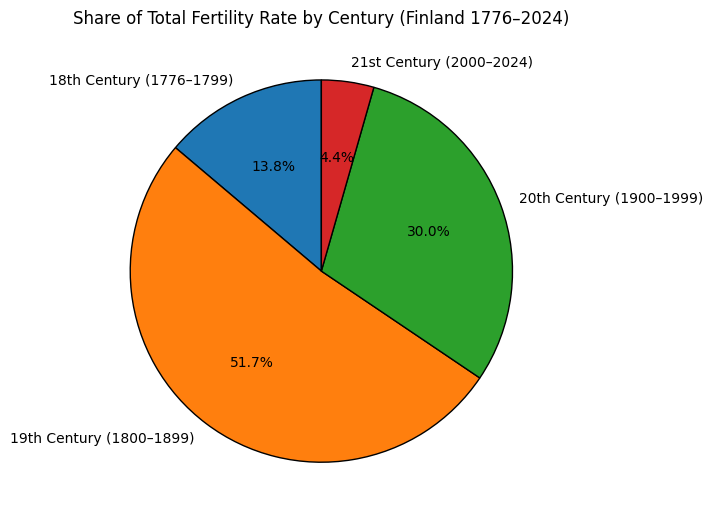

In [20]:
buckets = {
    "18th Century (1776–1799)": [str(y) for y in range(1776, 1800)],
    "19th Century (1800–1899)": [str(y) for y in range(1800, 1900)],
    "20th Century (1900–1999)": [str(y) for y in range(1900, 2000)],
    "21st Century (2000–2024)": [str(y) for y in range(2000, 2025)]
}
bucket_sums = []
bucket_labels = []
for label, years_list in buckets.items():
    mask = df_fertility["Year"].isin(years_list)
    total_for_bucket = df_fertility.loc[mask, "FertilityRate"].sum()
    bucket_sums.append(total_for_bucket)
    bucket_labels.append(label)

plt.figure(figsize=(7, 7))
plt.pie(
    bucket_sums,
    labels=bucket_labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"edgecolor": "k"}
)
plt.title("Share of Total Fertility Rate by Century (Finland 1776–2024)")
plt.tight_layout()
plt.savefig("fertility_rate_century_buckets_pie.png")
plt.show()

# Yhteenveto

Jupyter-notebookissa:
- Määritellään vuosilista 1776–2024 ja JSON-stat2-payload PX-Web-pyyntöön.
- Luodaan funktio `fetch_pxweb_data`, joka hakee JSON-stat2-datan ja muuntaa sen DataFrameksi sarakkeilla `Year`, `Indicator`, `FertilityRate`.
- Haetaan hedelmällisyysluvut vuodelta 1776–2024, näytetään DataFramen top 10 riviä ja rivien kokonaismäärä.
- Piirretään ja tallennetaan:
  1. Viivakuvaaja (line plot) 1776–2024 hedelmällisyysluvuista.
  2. Pylväskaavio (bar plot) vuodet 2015–2024.
  3. Ympyrädiagrammi (pie chart) summista neljällä aikakaudella (18.–21. vuosisata).
- Kaikki kuvaajat tallentuvat tiedostoiksi:
  - `fertility_rate_trend_line.png`
  - `fertility_rate_by_year_bar.png`
  - `fertility_rate_century_buckets_pie.png`